<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/Young_Adult_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Young Adult Group Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no 
    crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS

SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

- CURRENT RUN: ZNORM, MASK

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 1104, done.
remote: Counting objects: 100% (1104/1104), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 1104 (delta 697), reused 474 (delta 236), pack-reused 0
Receiving objects: 100% (1104/1104), 82.77 MiB | 11.41 MiB/s, done.
Resolving deltas: 100% (697/697), done.
/content/teambrainiac/source
access_data.py			  __init__.py
AccuracyMeasures.ipynb		  models
analysis.py			  process.py
cross_validation.py		  SingleSubjectSVM.ipynb
data				  SubjectVisualization_Models_ZNORM.ipynb
DataExploration_SingleSubj.ipynb  SVM_Group_Adolescent_Whole_brain.ipynb
DataExplorationVisuals.ipynb	  SVM_Group_YA_Whole_brain.ipynb
dataframes.py			  TestMask.ipynb
DL				  Timeseries_Cross_Validation.ipynb
Explore_data.ipynb		  train.py
file				  utils.py
Group_All_MASK_SVM.ipynb	  VisualizationPlayground.ipynb
Group_charts.ipynb		  Visualize_Data.ipynb
helper				  visualize.py
Images


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import plot_alphas
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 9.6 MB 30.8 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 8.7 MB 50.5 MB/s 
     |████████████████████████████████| 138 kB 67.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 127 kB 81.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 r

## Load Unmasked Data from AWS
- normalize and transform data
- and obtain Young Adult subjects from last 19 subject IDs

In [ ]:
from scipy import signal

# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
psc_norm = True
from_mat = 'unnorm' #unnorm
data_type = "YA_YA"
m_path_ind = 0 #get sub_mask data in mask_data key. // 1 is ROI
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Young Adult
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))


def masking_data(subject, mask, mask_labels, binary_labels, do_norm):
    """


    """

    arr = []
    label_arr = []
    for i in tqdm.tqdm(range(4)):
        user_key = 'run_0' + str(i + 1) + '_vec'
        array = subject[user_key]
        array_masked = array[:, mask]
        array_masked = array_masked[mask_labels]

        # Percent Signal Change normalization
        if do_norm:
            #array_masked = clean(array_masked, standardize='psc')
            array_masked = signal.detrend(array_masked,axis=0)

        arr.append(array_masked)
        label_arr.append(binary_labels)

    return arr, label_arr






def masked_data_n_labels(mask_type, label_type, path_dict, do_norm, m_path_ind, l_path_ind):
    """
    mask_type: String for type of mask we want
    label_type: String for which labels we want
    path_dict: dictionary that contains all the paths for data in AWS
    norm: To normalize on PSC True or False
    m_path_ind: the index to get either masks.mat or roi_masks.mat , 0 or 1 respectively
    l_path_ind: index to get the data from labels in dictionary
    Returns: a dictionary of subject masked data and the cleaned labels
    """
    # Define variable to return
    user_data_dict = defaultdict(list)

    # Mask path from S3
    mask_data_filepath = path_dict['mask_data'][m_path_ind]
    mask_type = mask_type  # 'mask'
    mask = create_mask(mask_data_filepath, mask_type)

    # Label path from S3
    label_data_path = path_dict['labels'][l_path_ind]
    label_type = label_type  # "rt_labels"

    # Returns two values, mask_labels_indices and binary_labels
    mask_labels_indices, binary_labels = labels_mask_binary(label_data_path, label_type)

    # Loop through all subjects
    for ind, val in tqdm.tqdm(enumerate(path_dict['subject_ID'])):
        sub_id = val
        sub_path = path_dict['subject_data'][ind]
        subject = access_load_data(sub_path, True)
        user_data_dict[sub_id], bi_lb = masking_data(subject, mask, mask_labels_indices, binary_labels, do_norm)
        user_data_dict[f"{sub_id}_{label_type}"] = bi_lb

    return user_data_dict

data = masked_data_n_labels(mask_type, label_type, data_path_dict, psc_norm, m_path_ind, l_path_ind) 

Number of subjects for Young Adult  19


0it [00:00, ?it/s]
100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
1it [00:17, 17.53s/it]
100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
2it [00:35, 17.79s/it]
100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
3it [00:53, 17.66s/it]
100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
4it [01:10, 17.69s/it]
100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
5it [01:28, 17.56s/it]
100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
6it [01:45, 17.62s/it]
100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
7it [02:03, 17.50s/it]
100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
8it [02:21, 17.79s/it]
100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
9it [02:38, 17.59s/it]
100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
10it [02:56, 17.56s/it]
100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
11it [03:14, 17.76s/it]
100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
12it [03:31, 17.69s/it]
100%|██████████| 4/4 [00:02<00:00,  1.44it/s]
13it [03:49, 17.57s/it]
100%|██████████| 4/4 [00:02<00:00,  1.44it/s]
14it [04:06, 17.55s/it]
100%|█████

In [ ]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
psc_norm = False
from_mat = 'unnorm' #unnorm
data_type = "YA_YA"
m_path_ind = 0 #get sub_mask data in mask_data key. // 1 is ROI
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Young Adult
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, psc_norm, m_path_ind, l_path_ind) 
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

Number of subjects for Young Adult  19
Loading in masked data
CPU times: user 27.5 s, sys: 56.2 s, total: 1min 23s
Wall time: 1min 45s


## SVM Young Adult
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [ ]:
# get train, test val data
train_ids = ya[:13]
val_ids = ya[13:16]
test_ids = ya[16:20]

data_type = "YA_detrend"
group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
znorm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization

print("Number of Young Adult training examples: ", len(train_ids))
print("Number of Young Adult validation examples: ", len(val_ids))
print("Number of Young Adult testing examples: ", len(test_ids))
print(len(ya))

model_dict = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, znorm, data_type)

Number of Young Adult training examples:  13
Number of Young Adult validation examples:  3
Number of Young Adult testing examples:  3
19
Normalizing Each based on RUNS...
Final X Train data shape (2184, 237979)
Final y Train data shape  (2184,)
Final X Val data shape (504, 237979)
Final y Val data shape  (504,)
Final X Test data shape (504, 237979)
Final y Test data shape  (504,)
Fitting the model for mask...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


upload complete for models/group/YA_detrend_[2, 3]_mask_X_y_model.pkl
Predicting on Validation set...
Validation Accuracy: 0.7837301587301587
Predicting on Test set...
Test Accuracy: 0.7797619047619048
upload complete for metrics/group_svm/mask/YA_detrend_[2, 3]_mask_metrics.pkl
upload complete for metrics/group_svm/mask/YA_detrend_model_[2, 3]_mask_validation_classreport.csv
Classification report for mask validation_classreport
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       252
           1       0.75      0.84      0.80       252

    accuracy                           0.78       504
   macro avg       0.79      0.78      0.78       504
weighted avg       0.79      0.78      0.78       504

upload complete for metrics/group_svm/mask/YA_detrend_model_[2, 3]_mask_test_classreport.csv
Classification report for mask test_classreport
              precision    recall  f1-score   support

           0       0.82      0.73      0.77 

### Detrending and znorm

In [ ]:
access_load_data("metrics/group_svm/mask/YA_detrend_model_[2, 3]_mask_test_classreport.csv", False)


,precision,recall,f1-score,support
0,0.778656,0.781746,0.780198,252.0
1,0.780876,0.777778,0.779324,252.0
2,NaN,NaN,0.779762,504.0
3,0.779766,0.779762,0.779761,504.0
4,0.779766,0.779762,0.779761,504.0


### znorm no detrending

In [ ]:
access_load_data("metrics/group_svm/mask/YA_YA_model_[2, 3]_mask_test_classreport.csv", False)

,precision,recall,f1-score,support
0,0.784861,0.781746,0.783300,252.0
1,0.782609,0.785714,0.784158,252.0
2,NaN,NaN,0.783730,504.0
3,0.783735,0.783730,0.783729,504.0
4,0.783735,0.783730,0.783729,504.0


## Visualization Analysis
- Load SVM pretrained model
- Load X train data and labels
- Check Support Vectors
- Create Alphas from dual coefficients/model weights and load into support vector indices
- Take the dot product of alphas and X train data and create a bmap
- Using the bmap we recreate the whole brain, 3d space using 3d mask indices and load information into this matrix (information are weights being applied to the X values by taking the dot product) 
- Use this information to visualize the areas of the brain that were learned by the SVM to be areas close to the decision boundary, areas thought of as either upregulating or downregulating

In [ ]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "YA_YA"
runs_train = [1,2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key


model_dict = access_load_data(f'models/group/{data_type}_{runs_id}_{mask_type}_X_y_model.pkl', False)
print(model_dict.keys())
clf = model_dict['model'][0]
X = model_dict['X_train'][0]
y = model_dict['y_train'][0]

dict_keys(['model', 'X_train', 'y_train'])


In [ ]:
print("number of support vectors:", len(clf.support_))
print("indices of support vectors:", clf.support_)
print("support vector shape: ", clf.support_vectors_.shape)
print("number of support vectors for each class:", clf.n_support_)
print("# Values scaled to fit between -1 and 1:", clf.dual_coef_.shape)
print("length of X-train:", len(X))

number of support vectors: 1602
indices of support vectors: [  14   15   16 ... 2174 2175 2176]
support vector shape:  (1602, 237979)
number of support vectors for each class: [819 783]
# Values scaled to fit between -1 and 1: (1, 1602)
length of X-train: 2184


#### Create Beta map for Visualization
- Create Alphas and Bmaps

In [ ]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)

# Load in the mask indices to create bmaps
indices_mask = load_mask_indices(data_path_dict, mask_type, m_path_ind)
bmap3, bmap2_3, alphas1 = create_bmaps(clf, X, indices_mask, affine_image)


mask shape: (79, 95, 79)
Shape of beta map:  (1, 237979)


In [ ]:
# View Slices of the brain
# get bmaps for visualization
outfile = None

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_plt_z_1.png"

title = f"Young Adult {mask_type}"
im = plotting.plot_img(bmap3, 
                        bg_img = t1_image,
                        colorbar=True, 
                        cut_cords = (-35,-20,0,20,35,50,65,70),
                        cmap='cold_white_hot', 
                        display_mode='z',
                        output_file = output_file
                        )
im.title(title, 
        x=0.01, 
        y=0.99, 
        size=15, 
        color='w', 
        bgcolor='black'
        )



# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = None
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Young Adult {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Young Adult {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_img(threshold_percentile_img, 
                        bg_img = t1_image, 
                        display_mode='y', 
                        cut_coords=cut_cords = (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file1
                       )
im2.title(title2, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='w', 
          bgcolor='black'
          )

# Showing intensity threshold image
im3 = plotting.plot_img(threshold_value_img, 
                        bg_img = t1_image, 
                        display_mode='y', 
                        cut_coords=cut_cords = (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file2
                       )
im3.title(title3, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='w', 
          bgcolor='black'
          )





def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')


# Plot the time series with alpha signals and labels
title = f"Young Adult Group {mask_type} Last"

timepoints = [(200, -2, 2)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)



# Plot interactive maps     
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=[-10, 13, -8],
                              title=f"Young Adult {mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_1.html')



"""
# Plotting all slices in brain
title = f'Threshold image with intensity value for Young Adult {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullsliceCOLDhot.png"
plotting.plot_img(bmap3, 
                  #threshold_percentile_img, 
                  bg_img = t1_image, 
                  #display_mode='z', 
                  cut_coords=(1, 55, -22), 
                  annotate = True,
                  #title=title, 
                  colorbar=True,
                  cmap = "cold_hot",
                  output_file=output_file3
                  )"""

In [ ]:
# View Slices of the brain
# get bmaps for visualization
#title = f"Young Adult {mask_type}"
output_file = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_statmap_z_1.png"

plotting.plot_stat_map(bmap3, 
                       bg_img = t1_image,
                       colorbar=True, 
                       cmap='hot', 
                       display_mode='z',
                       #title=f"{title}",
                       output_file = output_file
                       )

In [ ]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)
output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


# Plotting image thresholded by percentile
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'98th percentile Signal threshold Young Adult {mask_type}',
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file1
                       )

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'Image intensity threshold Young Adult {mask_type}', 
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file2
                       )

In [ ]:
def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')

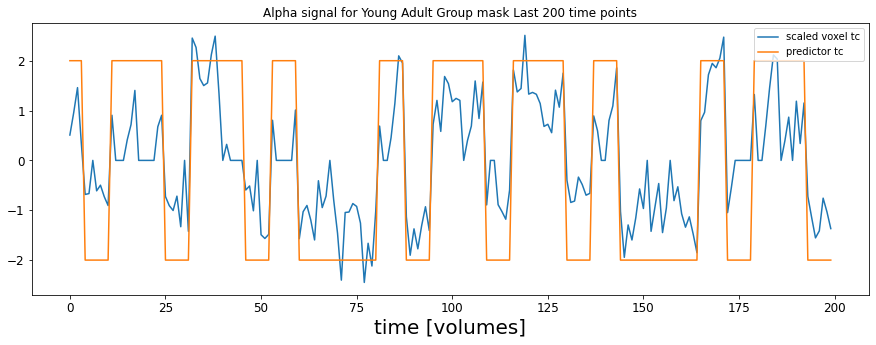

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the time series with alpha signals and labels
title = f"Young Adult Group {mask_type} Last"

timepoints = [(200, -2, 2)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)

In [ ]:
# Plot interactive maps     
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              #cmap = 'hot', 
                              cut_coords=[-10, 13, -8],
                              title=f"Young Adult {mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_1.html')

In [ ]:
# Plotting all slices in brain
title = f'Threshold image with intensity value for Young Adult {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullsliceCOLDhot.png"
plotting.plot_stat_map(bmap3, #threshold_percentile_img, 
                       bg_img = t1_image, 
                       #display_mode='z', 
                       cut_coords=(1, 55, -22), 
                       annotate = True,
                       #title=title, 
                       colorbar=True,
                       cmap = "cold_hot",
                       output_file=output_file3
                       )

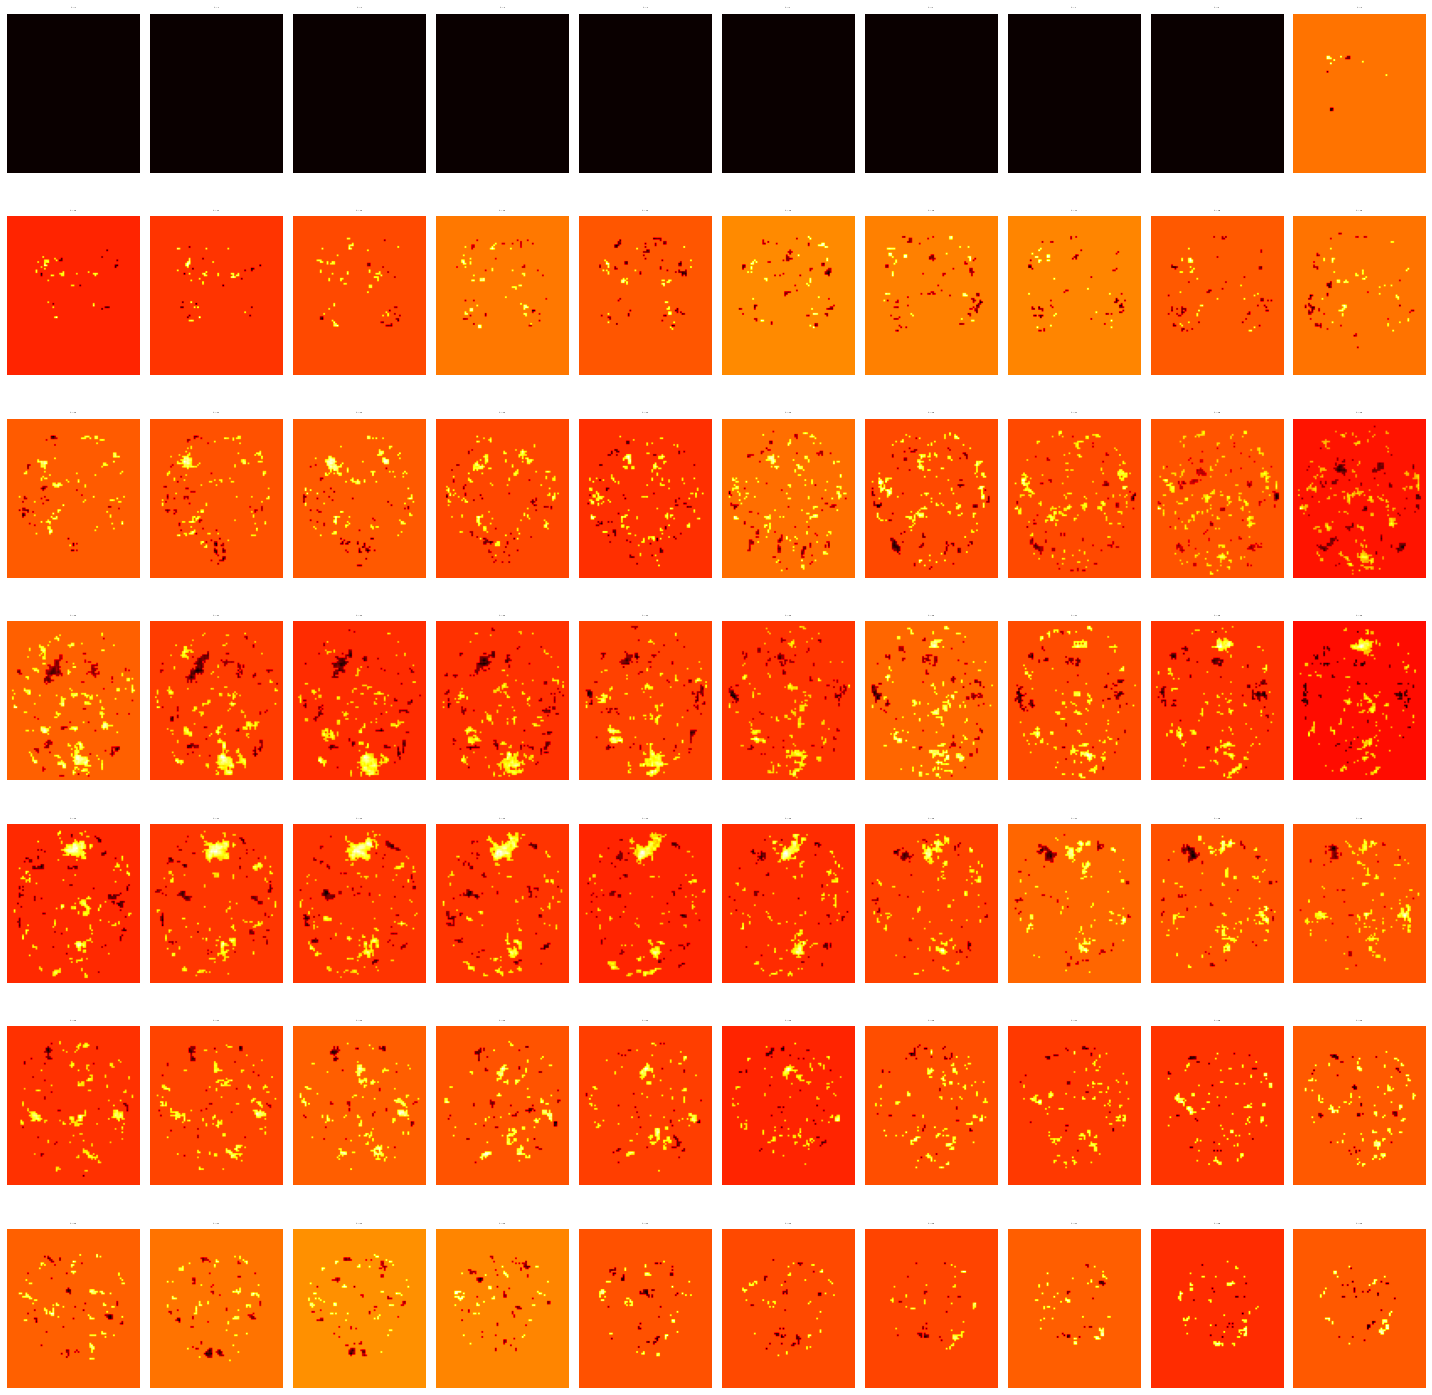

In [ ]:
fig, axes = plt.subplots(ncols=10, nrows=7, figsize=(20, 20))  # 70 slices
# Loop over the first 70 slices
for t, ax in enumerate(axes.flatten()):   
    ax.imshow(bmap2_3[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

## Predict Young Adult Brain states on model trained with Adolescent Data

In [ ]:
# get train, test val data
train_ids = ya[:13]
val_ids = ya[13:16]
test_ids = ya[16:20]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
model_type = "Adolescent"
data_type = "YA_Adol"
runs_id = [i+1 for i in runs_train]

print("Number of Youth training examples: ", len(train_ids))
print("Number of Youth validation examples: ", len(val_ids))
print("Number of Youth testing examples: ", len(test_ids))
print(len(ya))

X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)


# Load Adolescent model
model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
print(model_dict.keys())
clf = model_dict['model'][0]


metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type, model_type)

Number of Youth training examples:  13
Number of Youth validation examples:  3
Number of Youth testing examples:  3
19
Normalizing Each based on RUNS...
Final X Train data shape (2184, 237979)
Final y Train data shape  (2184,)
Final X Val data shape (504, 237979)
Final y Val data shape  (504,)
Final X Test data shape (504, 237979)
Final y Test data shape  (504,)
dict_keys(['model', 'X_train', 'y_train'])
Predicting on Validation set...
Validation Accuracy: 0.7599206349206349
Predicting on Test set...
Test Accuracy: 0.8075396825396826
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       252
           1       0.73      0.83      0.78       252

    accuracy                           0.76       504
   macro avg       0.77      0.76      0.76       504
weighted avg       0.77      0.76      0.76       504

Classification report for whole_brain test_classreport
              pre

True

In [ ]:
# Load Adolescent model
model_type = "YA_YA"
data_type = "YA_YA"
runs_train = [1,2]
runs_id = [i+1 for i in runs_train]
mask_type = "mask"
znorm = "RUNS"
#model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
#print(model_dict.keys())
#clf = model_dict['model'][0]

X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, znorm)
#metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type)

Normalizing Each based on RUNS...
Final X Train data shape (2184, 237979)
Final y Train data shape  (2184,)
Final X Val data shape (504, 237979)
Final y Val data shape  (504,)
Final X Test data shape (504, 237979)
Final y Test data shape  (504,)


In [ ]:
d = clf.support_vectors_
d.shape

(1602, 237979)

In [ ]:
y_decision_score = clf.decision_function(X_t)


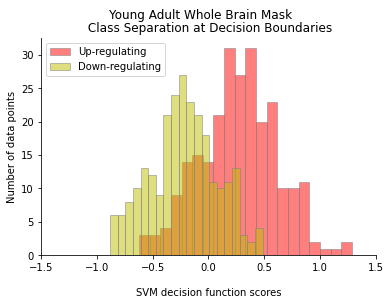

In [ ]:
y_decision_score = clf.decision_function(X_t)
y_negative_decision_score = y_decision_score[y_t == 0]
y_positive_decision_score = y_decision_score[y_t == 1]


ax = plt.subplot()
# plot the two histograms
plt.hist(y_positive_decision_score, bins = 20, alpha=0.5, label='Up-regulating', color='r', histtype='bar', ec='gray')
plt.hist(y_negative_decision_score, bins = 20, alpha=0.5, label='Down-regulating', color='y', histtype='bar', ec='gray')
ax.spines["right"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
#ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlim(-1.5, 1.5)
plt.legend(loc = "upper left")
plt.xlabel('\nSVM decision function scores')
plt.ylabel('Number of data points')
plt.suptitle("Young Adult Whole Brain Mask \n\n")
plt.title("\n Class Separation at Decision Boundaries")
plt.savefig('/content/gdrive/MyDrive/YA_decision_hist2.png', dpi=200, transparent=True)
plt.show()


In [ ]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Young Adult Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "\nUnnormalized": [.49, .54, .51, .49, .50, .51],
              "\nPSC": [.49, .61, .60, .62, .50, .56 ],
              "\nPSC+ZNorm": [.77, .76, .82, .79, .80, .79],
              "\nZNorm": [.77, .75, .82, .81, .80, .79]}

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Young Adult Train run 2/Test run 3", inplace = True)
df

,\nUnnormalized,\nPSC,\nPSC+ZNorm,\nZNorm
Cross Validation Young Adult Train run 2/Test run 3,,,,
1,0.49,0.49,0.77,0.77
2,0.54,0.61,0.76,0.75
3,0.51,0.60,0.82,0.82
4,0.49,0.62,0.79,0.81
5,0.50,0.50,0.80,0.80
Average,0.51,0.56,0.79,0.79


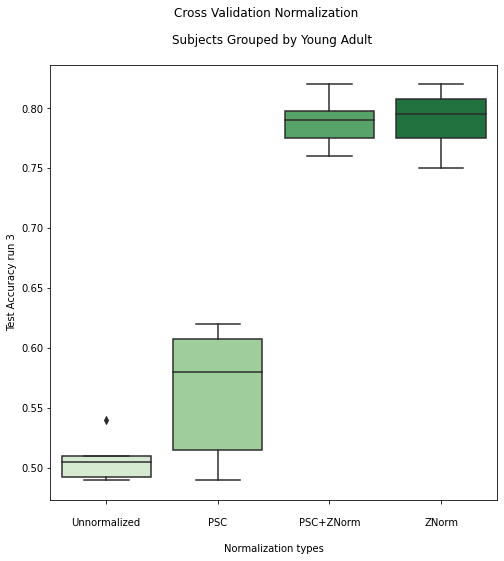

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
sns.boxplot(data = df, palette="Greens")
plt.xlabel("\nNormalization types")
plt.ylabel("Test Accuracy run 3")
plt.suptitle("Cross Validation Normalization")
plt.title("Subjects Grouped by Young Adult \n")
plt.savefig('/content/gdrive/MyDrive/YA_norm_box.png', dpi=200, transparent=True)
plt.show()

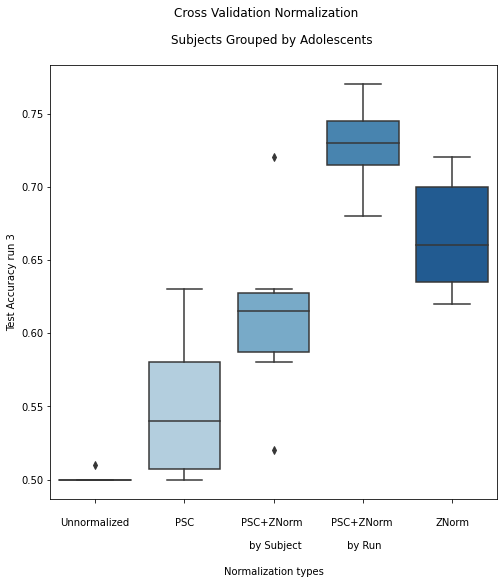

In [ ]:
## Cross Validation accuracy scores recorded

dictionarya = {"Cross Validation Adolescent Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "\nUnnormalized": [.50, .51, .50, .50, .50, .50],
              "\nPSC": [.53, .63, .50, .50, .59, .55 ], 
              "\nPSC+ZNorm \n\n by Subject": [.63, .72, .62, .58, .52, .61], 
              "\nPSC+ZNorm \n\n by Run": [.68, .75, .73, .71, .77, .73], 
              "\nZNorm": [.62, .71, .72, .65, .63, .67]
              }

dfa = pd.DataFrame(dictionarya)
dfa.set_index("Cross Validation Adolescent Train run 2/Test run 3", inplace = True)
plt.figure(figsize = (8, 8))
sns.boxplot(data = dfa, palette="Blues")
plt.xlabel("\nNormalization types")
plt.ylabel("Test Accuracy run 3")
sns.color_palette("tab10")
plt.suptitle("Cross Validation Normalization")
plt.title("Subjects Grouped by Adolescents \n")
plt.savefig('/content/gdrive/MyDrive/AD_norm_box.png', dpi=200, transparent=True)
plt.show()


In [ ]:
df

,Unnormalized,PSC,PSC + Z Norm,Z Norm
Cross Validation Young Adult Train run 2/Test run 3,,,,
1,0.49,0.49,0.77,0.77
2,0.54,0.61,0.76,0.75
3,0.51,0.60,0.82,0.82
4,0.49,0.62,0.79,0.81
5,0.50,0.50,0.80,0.80
Average,0.51,0.56,0.79,0.79
